In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as lf
import sklearn as sk

In [2]:
# let's get our data
data = pd.read_csv('clean/afib_434_4_clean.csv')
data.describe()

,duration,event,age,sex_0.0,sex_1.0,race_1.0,race_2.0,race_3.0,race_4.0,race_5.0,race_6.0,race_9.0
count,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000,12736.000000
mean,1188.200612,0.769237,75.335637,0.411354,0.588646,0.394394,0.041536,0.079224,0.040829,0.000314,0.004790,0.438913
std,777.870643,0.421338,10.957782,0.492098,0.492098,0.488739,0.199534,0.270099,0.197902,0.017720,0.069044,0.496274
min,1.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,544.000000,1.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1099.000000,1.000000,77.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1754.000000,1.000000,83.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3289.000000,1.000000,101.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
T, E = data['duration'], data['event']
data.shape[0] # number of patients

12736

In [4]:
censorship_counts = data['event'].value_counts()
censor_rate = censorship_counts[0] / censorship_counts.sum()
print('Censor Rate:', str(round(censor_rate, 2)*100) + '%')

Censor Rate: 23.0%


In [5]:
censorship_counts

1.0    9797
0.0    2939
Name: event, dtype: int64

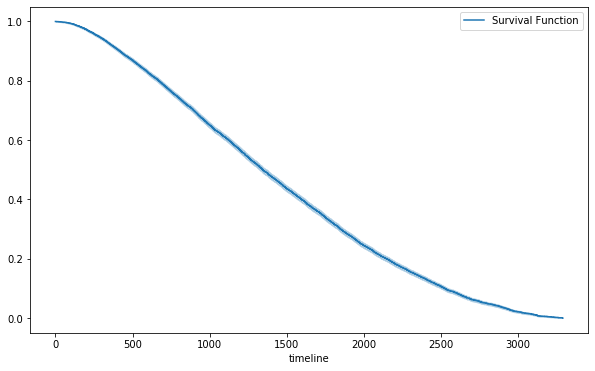

In [6]:
kmf = lf.KaplanMeierFitter().fit(T, E, label='Survival Function')
kmf.plot(figsize=(10,6))

In [7]:
kmf.median_survival_time_

1343.0

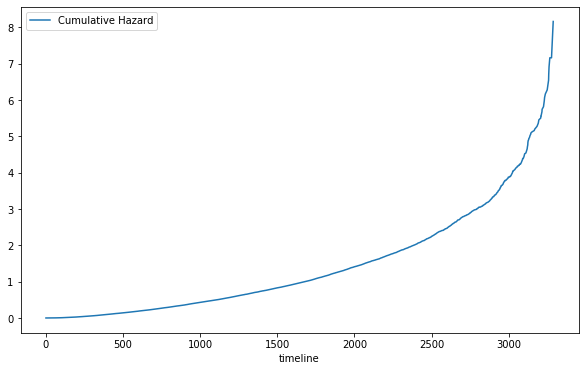

In [8]:
naf = lf.NelsonAalenFitter().fit(T, E, label='Cumulative Hazard')
naf.cumulative_hazard_.plot(figsize=(10,6))

### Univariate Parametric Models

##### Hazard Estimates

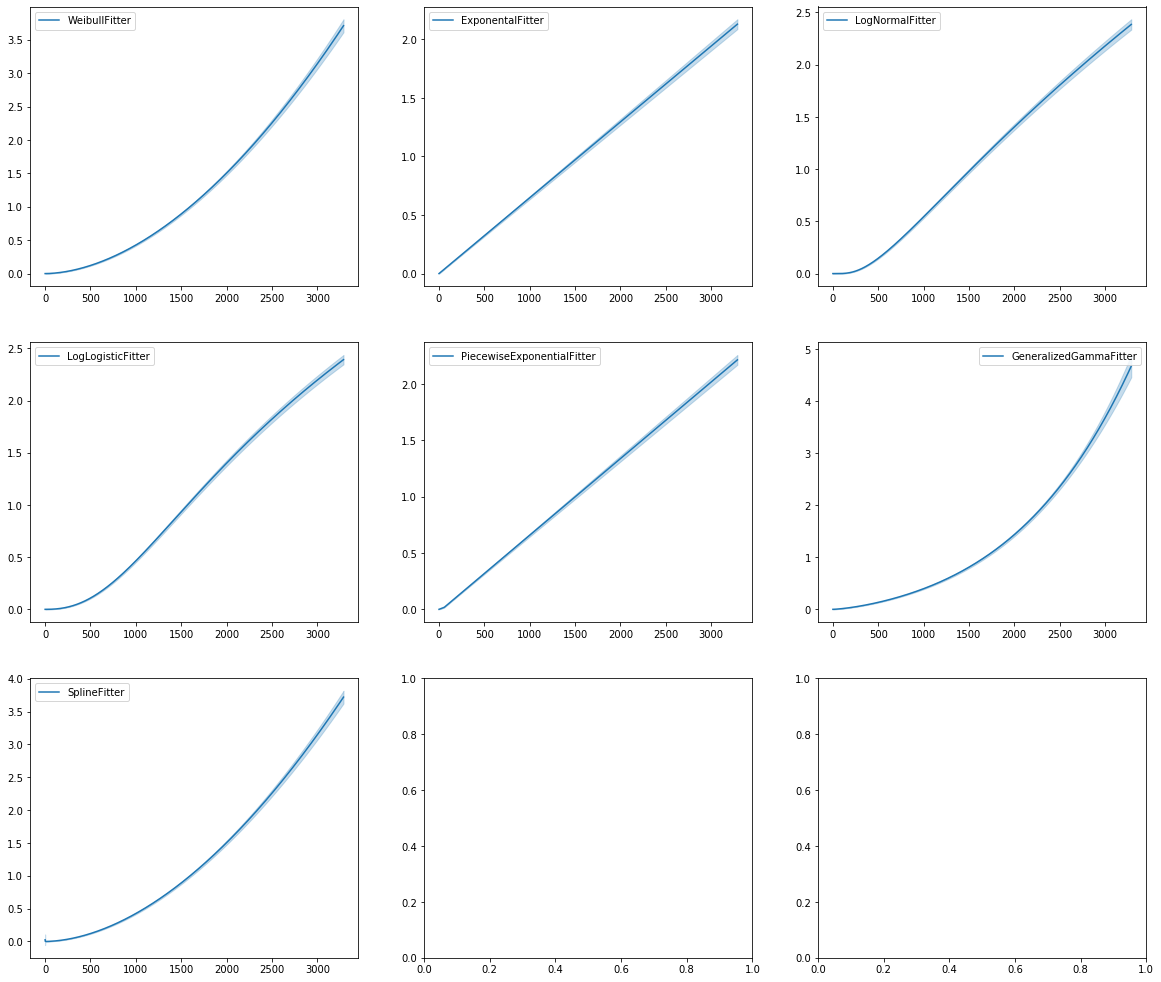

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(20, 17.5))

wbf = lf.WeibullFitter().fit(T, E, label='WeibullFitter')
exf = lf.ExponentialFitter().fit(T, E, label='ExponentalFitter')
lnf = lf.LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = lf.LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = lf.PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
gg = lf.GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
spf = lf.SplineFitter([6, 20, 40, 75]).fit(T, E, label='SplineFitter')

wbf.plot_cumulative_hazard(ax=axes[0][0])
exf.plot_cumulative_hazard(ax=axes[0][1])
lnf.plot_cumulative_hazard(ax=axes[0][2])
llf.plot_cumulative_hazard(ax=axes[1][0])
pwf.plot_cumulative_hazard(ax=axes[1][1])
gg.plot_cumulative_hazard(ax=axes[1][2])
spf.plot_cumulative_hazard(ax=axes[2][0])

##### Survival Estimates

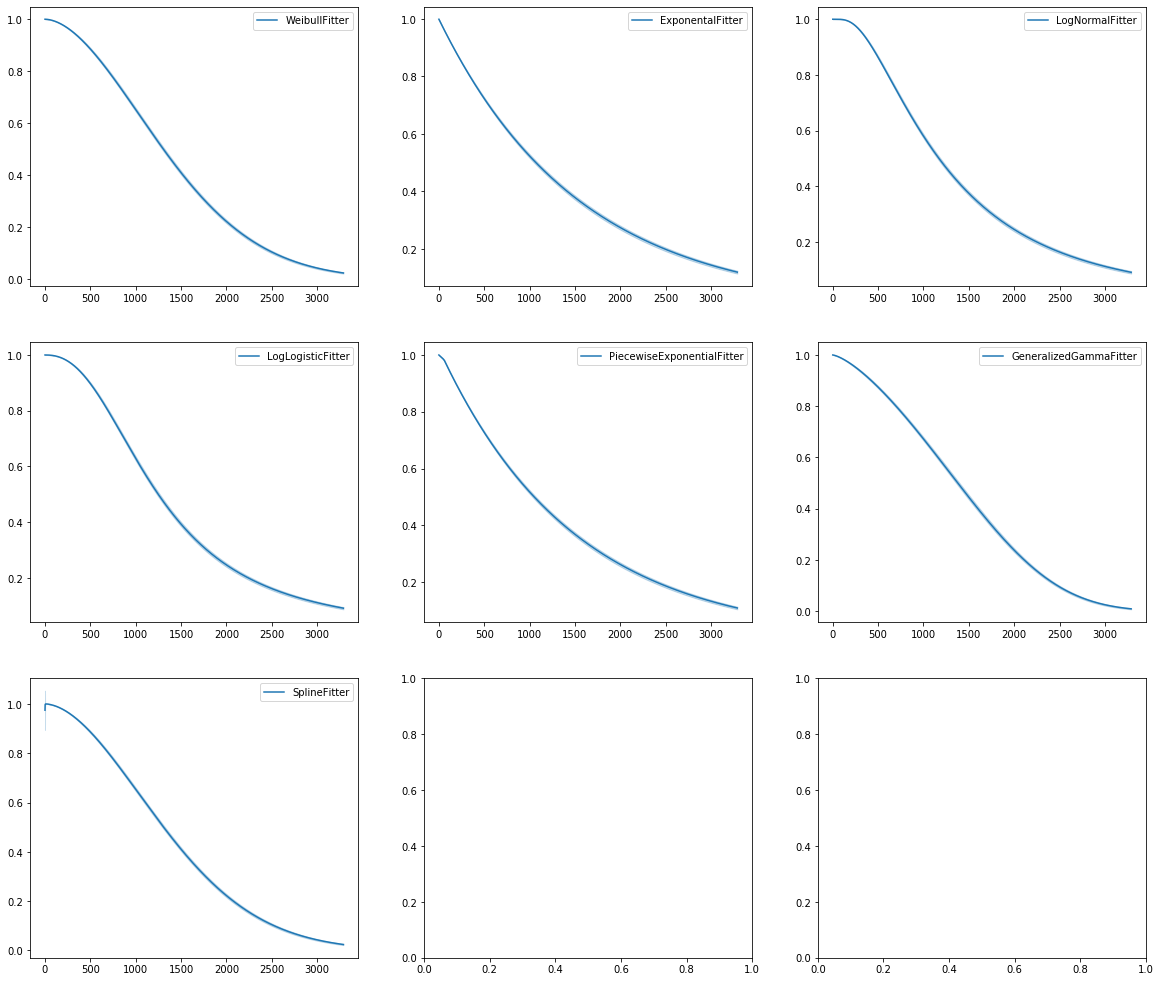

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(20, 17.5))

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
llf.plot_survival_function(ax=axes[1][0])
pwf.plot_survival_function(ax=axes[1][1])
gg.plot_survival_function(ax=axes[1][2])
spf.plot_survival_function(ax=axes[2][0])

### Check Parametric with Best Fit

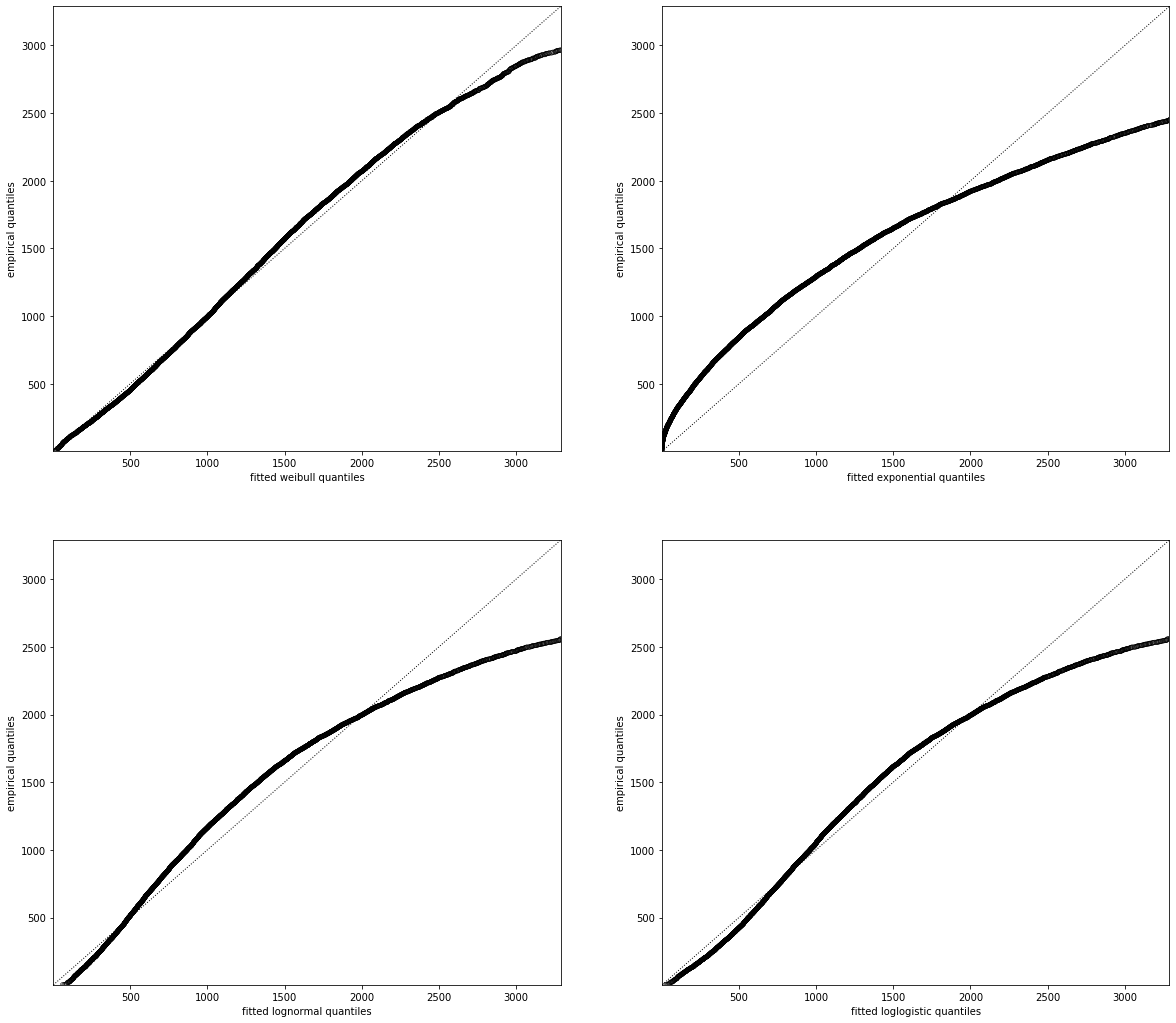

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.reshape(4,)

for i, model in enumerate([wbf, exf, lnf, llf]):
    model.fit(T, E)
    lf.plotting.qq_plot(model, ax=axes[i])

### Find Best Parametric with AIC

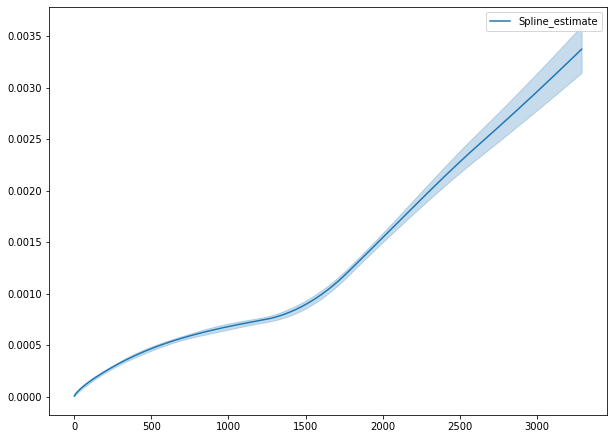

In [12]:
best_model, best_aic_ = lf.utils.find_best_parametric_model(T, E)
best_model.plot_hazard(figsize=(10, 7.5))

In [13]:
best_model.median_survival_time_

array(1360.57555475)

### Survival Curves by Sex

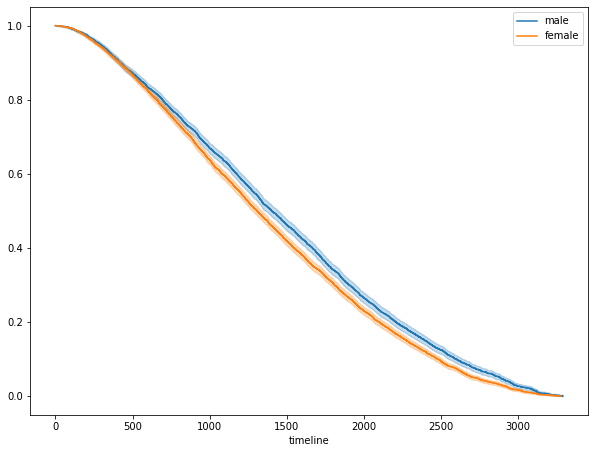

In [14]:
ax = plt.subplot(111)
male = (data['sex_0.0'] == 1)
female = (data['sex_1.0'] == 1)
kmf = lf.KaplanMeierFitter()
kmf.fit(T[male], E[male], label='male')
kmf.plot(ax=ax, figsize=(10,7.5))

kmf.fit(T[female], E[female], label='female')
kmf.plot(ax=ax)

In [15]:
results = lf.statistics.logrank_test(T[male], T[female], \
                                     E[male], E[female], alpha=.99)
results.print_summary()

### Survival Curves by Race

In [16]:
results = {}
i = 0
for race1 in ['race_1.0','race_2.0','race_3.0','race_4.0','race_5.0','race_6.0','race_9.0',]:
    for race2 in ['race_1.0','race_2.0','race_3.0','race_4.0','race_5.0','race_6.0','race_9.0',]:
        if race1 == race2:
            continue
        
        if (race2[5] + '-' + race1[5]) in results:
            continue
            
        r1 = (data[race1] == 1)
        r2 = (data[race2] == 1)
        
        resKey = (race1[5] + '-' + race2[5])
        
        results[resKey] = lf.statistics.logrank_test(T[r1], T[r2], \
                                         E[r1], E[r2], alpha=.99)
        i += 1

In [17]:
for k in results:
    print(k)
    results[k].print_summary()

1-2


1-3


1-4


1-5


1-6


1-9


2-3


2-4


2-5


2-6


2-9


3-4


3-5


3-6


3-9


4-5


4-6


4-9


5-6


5-9


6-9


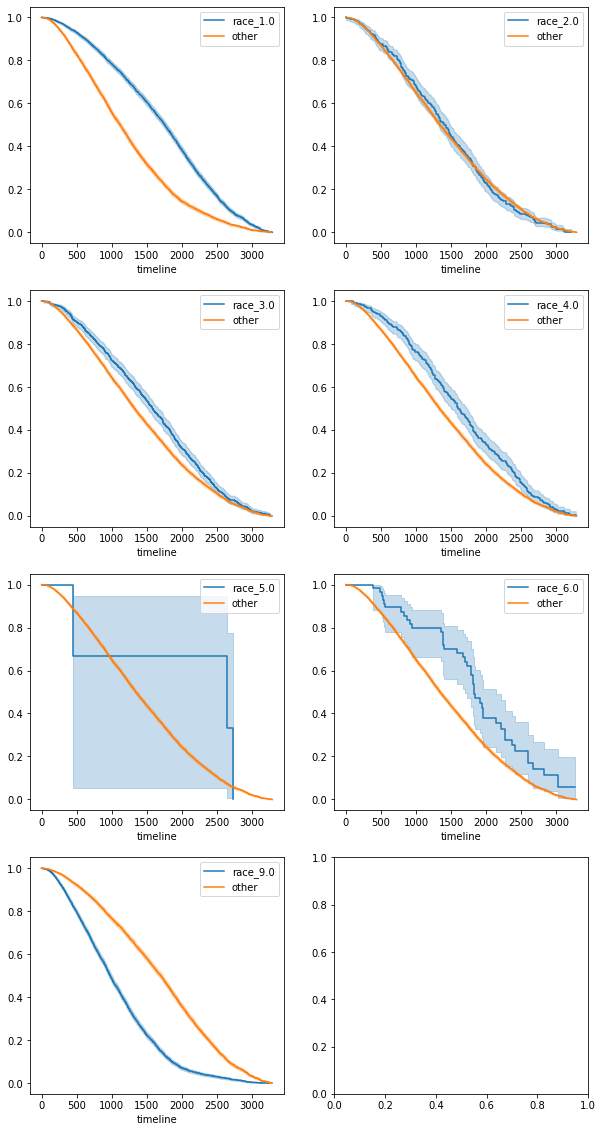

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
i = 0
j = 0

for race in ['race_1.0','race_2.0','race_3.0','race_4.0','race_5.0','race_6.0','race_9.0',]:
    r1 = (data[race] == 1)
    other = (data[race] != 1)
    
    kmf = lf.KaplanMeierFitter()
    
    kmf.fit(T[r1], E[r1], label=race)
    kmf.plot(ax=axes[i][j])

    kmf.fit(T[other], E[other], label='other')
    kmf.plot(ax=axes[i][j])
    
    j = (j + 1) % 2
    
    if j == 0:
        i += 1